# 0 - Установка зависимостей

In [1]:
!pip install nemo_toolkit[asr]==2.5.0 datasets==3.6.0 pyctcdecode kenlm jiwer -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB

Перезапустите среду выполнения после установки библиотек

In [1]:
import os
import ast
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

import torch
import torchaudio
import torch.nn.functional as F

from huggingface_hub import login
from datasets import load_dataset

from jiwer import wer, cer
from pyctcdecode import build_ctcdecoder

import nemo.collections.asr as nemo_asr

import kenlm


# 1 - Подготовка данных

В этом разделе мы загрузим и изучим структуру медицинского датасета, который будет являтся вне-доменным для предобученной ASR модели

Для загрузки Eka Medical ASR Evaluation датасета вам нужно получить доступ к датасету на его странице https://huggingface.co/datasets/ekacare/eka-medical-asr-evaluation-dataset

In [2]:
login()

In [2]:
dataset = load_dataset('ekacare/eka-medical-asr-evaluation-dataset', 'en', split='test')

Some datasets params were ignored: ['default_preview_rows']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.
Some datasets params were ignored: ['default_preview_rows']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.


In [10]:
print(f"Количество аудио: {len(dataset)}")


Количество аудио: 3619


In [5]:
print(f"Доступные поля в данных: \n{', '.join(list(dataset.features.keys()))}")

Доступные поля в данных: 
md5_text, file_name, audio, md5_audio, duration, text, audio_language, text_language, session_id, speaker, type_concept, recording_context, medical_entities


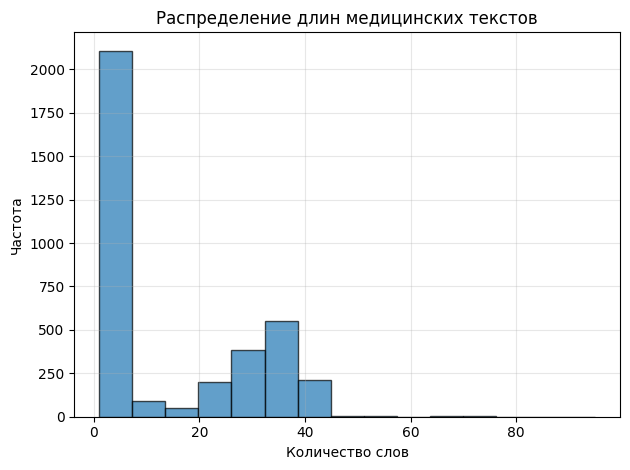

In [6]:
text_lengths = [len(t.split()) for t in dataset["text"]]

plt.hist(text_lengths, bins=15, alpha=0.7, edgecolor='black')
plt.title('Распределение длин медицинских текстов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


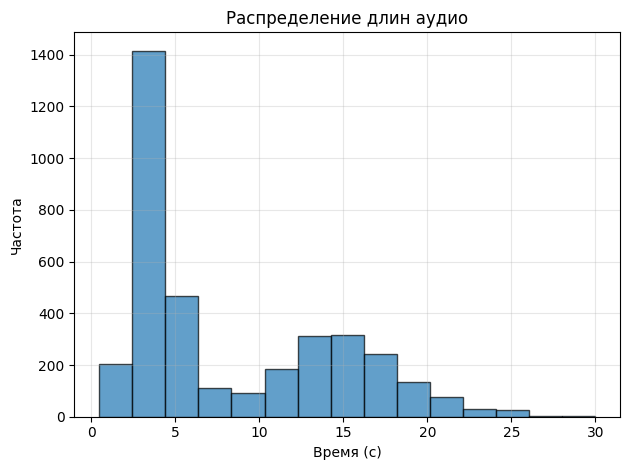

In [7]:
plt.hist(dataset["duration"], bins=15, alpha=0.7, edgecolor='black')
plt.title('Распределение длин аудио')
plt.xlabel('Время (с)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
text_languages = np.unique(dataset["text_language"])

print(f"Доступные языки текста: {', '.join(text_languages)}")


Доступные языки текста: en


In [9]:
audio_languages = np.unique(dataset["audio_language"])

print(f"Доступные языки аудио: {', '.join(audio_languages)}")


Доступные языки аудио: en


In [11]:
for i in range(3):
    print(f"Пример {i+1}:")
    print(f"  {dataset['text'][i]}")
    print()


Пример 1:
  not having adequate rest. Okay okay. So that continues for better part of the day. Hmm, hmm, hmm. Then

Пример 2:
  2 times in a day, please have, an antibiotic named azithromycin.

Пример 3:
  500 mg. Also, Because you're feeling weak. Take Zincovit once in a day.



In [12]:
ipd.Audio(dataset[1]['audio']['array'], rate=dataset[1]['audio']['sampling_rate'])


# 2 - Инициализация CTC Conformer и валидация на датасете

Загрузим предобученную модель Conformer-CTC и оценим её производительность на медицинском датасете.


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "nvidia/stt_en_conformer_ctc_large"

model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name=model_name)
model.eval()
model = model.to(device)


stt_en_conformer_ctc_large.nemo:   0%|          | 0.00/451M [00:00<?, ?B/s]

[NeMo I 2025-10-31 20:46:54 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-10-31 20:46:54 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2025-10-31 20:46:54 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librisp

[NeMo I 2025-10-31 20:46:54 nemo_logging:393] PADDING: 0
[NeMo I 2025-10-31 20:46:56 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_ctc_large/snapshots/5f18b90411b9fdfc9b52b8caf636f204491afb01/stt_en_conformer_ctc_large.nemo.


In [14]:
def validate(model, dataset, target_sr, num_samples=100):
    eval_samples = dataset.select(range(min(num_samples, len(dataset))))

    references = []
    predictions = []

    for i, sample in enumerate(tqdm(eval_samples, total=num_samples)):
        signal = np.array(sample['audio']['array'], dtype=np.float32)
        sr = sample['audio']['sampling_rate']

        if sr != target_sr:
            signal = torchaudio.functional.resample(signal, sr, target_sr)

        transcription = model.transcribe([signal], batch_size=1, verbose=False)[0].text

        references.append(sample['text'].lower())
        predictions.append(transcription.lower())

    return references, predictions


In [36]:
references, predictions = validate(model, dataset, target_sr=16000, num_samples=100)


  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
wer_score = wer(references, predictions)
cer_score = cer(references, predictions)

print(f"WER: {wer_score:.4f}")
print(f"CER: {cer_score:.4f}")


WER: 0.4570
CER: 0.1923


In [18]:
print("\nАнализ ошибок (первые 3 примера):")
error_count = 0
for i, (ref, pred) in enumerate(zip(references, predictions)):
    if ref != pred and error_count < 3:
        print(f"\nПример {i+1}:")
        print(f"  Референс: {ref}")
        print(f"  Предсказание: {pred}")
        error_count += 1



Анализ ошибок (первые 3 примера):

Пример 1:
  Референс: not having adequate rest. okay okay. so that continues for better part of the day. hmm, hmm, hmm. then
  Предсказание: uh not having adequate rest so that continues uh for a better part of the day than a

Пример 2:
  Референс: 2 times in a day, please have, an antibiotic named azithromycin.
  Предсказание: uh two times in a day please have um an antibiotic name az itromycin

Пример 3:
  Референс: 500 mg. also, because you're feeling weak. take zincovit once in a day.
  Предсказание: five hundred m g also uh because you're feeling weak takes in covid once in a day


In [21]:
ipd.Audio(dataset[2]['audio']['array'], rate=dataset[2]['audio']['sampling_rate'])


In [4]:
def normalize_reference(text, vocab):
    new_text = ""
    for char in text:
        if char in vocab or char.isdigit():
            new_text += char
    text = new_text

    def number_to_words(num):
        num = int(num)
        if num <= 20:
            numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                      'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty']
            return numbers[num]
        elif num < 100:
            tens = ['twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety']
            return tens[num//10 - 2] + (' ' + number_to_words(num%10) if num%10 != 0 else '')
        elif num < 1000:
            return number_to_words(num//100) + ' hundred' + (' ' + number_to_words(num%100) if num%100 != 0 else '')
        else:
            return str(num)

    words = []
    for word in text.split():
        if word.isdigit():
            words.append(number_to_words(int(word)))
        else:
            words.append(word)

    return ' '.join(words)


In [5]:
vocab = set("".join(model.tokenizer.vocab))
vocab.add(" ")

In [42]:
references = [normalize_reference(t, vocab) for t in references]


In [43]:
wer_score = wer(references, predictions)
cer_score = cer(references, predictions)

print(f"WER: {wer_score:.4f}")
print(f"CER: {cer_score:.4f}")


WER: 0.2796
CER: 0.1351


In [44]:
print("\nАнализ ошибок (первые 3 примера):")
error_count = 0
for i, (ref, pred) in enumerate(zip(references, predictions)):
    if ref != pred and error_count < 3:
        print(f"\nПример {i+1}:")
        print(f"  Референс: {ref}")
        print(f"  Предсказание: {pred}")
        error_count += 1



Анализ ошибок (первые 3 примера):

Пример 1:
  Референс: not having adequate rest okay okay so that continues for better part of the day hmm hmm hmm then
  Предсказание: uh not having adequate rest so that continues uh for a better part of the day than a

Пример 2:
  Референс: two times in a day please have an antibiotic named azithromycin
  Предсказание: uh two times in a day please have um an antibiotic name az itromycin

Пример 3:
  Референс: five hundred mg also because you're feeling weak take zincovit once in a day
  Предсказание: five hundred m g also uh because you're feeling weak takes in covid once in a day


# 3 - Beam Search и OracleWER

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = "nvidia/stt_en_conformer_ctc_large"

model = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name=model_name)
model.eval()
model = model.to(device)


[NeMo I 2025-10-31 21:17:56 nemo_logging:393] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2025-10-31 21:17:56 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/NeMo_ASR_SET/English/v2.0/train/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 32
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 20.0
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/NeMo_ASR_SET/English/v2.0/train/audio__OP_0..4095_CL_.tar
    
[NeMo W 2025-10-31 21:17:56 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /data/ASR/LibriSpeech/librisp

[NeMo I 2025-10-31 21:17:56 nemo_logging:393] PADDING: 0
[NeMo I 2025-10-31 21:17:59 nemo_logging:393] Model EncDecCTCModelBPE was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_ctc_large/snapshots/5f18b90411b9fdfc9b52b8caf636f204491afb01/stt_en_conformer_ctc_large.nemo.


In [49]:
def validate_beam_search(model, dataset, target_sr=16000, num_samples=50, beam_width=10):
    eval_samples = dataset.select(range(min(num_samples, len(dataset))))

    labels = model.decoder.vocabulary
    decoder = build_ctcdecoder(
        labels,
        alpha=0.0,  # без языковой модели
        beta=0.0,   # без регуляризации на длину
    )

    all_candidates = []
    references = []

    for sample in tqdm(eval_samples):
        signal = np.array(sample['audio']['array'], dtype=np.float32)
        sr = sample['audio']['sampling_rate']

        if sr != target_sr:
            signal = torchaudio.functional.resample(signal, sr, target_sr)

        with torch.no_grad():
            input_signal = torch.tensor(signal).unsqueeze(0).to(device)
            input_signal_length = torch.tensor([len(signal)]).to(device)

            signal, length = model.preprocessor(
                input_signal=input_signal,
                length=input_signal_length
            )

            encoded, encoded_length = model.encoder(audio_signal=signal, length=length)

            log_probs = model.decoder(encoder_output=encoded)  # (batch_size, num_frames, vocab_size)
        log_probs = log_probs.cpu().numpy()[0]

        # Получаем несколько кандидатов через beam search
        beam_results = decoder.decode_beams(
            log_probs,
            beam_width=beam_width,
        )

        candidates = [result[0].lower() for result in beam_results]

        references.append(sample['text'].lower())
        all_candidates.append(candidates)

    return all_candidates, references


In [50]:
candidates, references = validate_beam_search(
    model, dataset, target_sr=16000, num_samples=100, beam_width=25
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
references = [normalize_reference(t, vocab) for t in references]


Вычисляем Oracle WER (лучший WER среди кандидатов)


In [52]:
oracle_wers = []
for ref, can in zip(references, candidates):
    candidate_wers = [wer([ref], [t.lower()]) for t in can]
    best_wer = min(candidate_wers)
    oracle_wers.append(best_wer)

oracle_wer = np.mean(oracle_wers)
print(f"Oracle WER: {oracle_wer:.4f}")


Oracle WER: 0.2773


# 4 - Инференс pyctcdecode с hotwords

Для начала необходимо собрать медицинские термины

In [54]:
ast.literal_eval(dataset['medical_entities'][1])

[['2 times in a day', 'advices', [[0, 16]]],
 ['antibiotic', 'drugs', [[34, 44]]],
 ['azithromycin', 'drugs', [[51, 63]]]]

In [55]:
hotwords = []

for entity in dataset['medical_entities']:
    entity = ast.literal_eval(entity)
    for (phrase, p_type, token_positions) in entity:
        if p_type == 'drugs':
            phrase = normalize_reference(phrase.lower(), vocab)
            hotwords.append(phrase)

hotwords = list(set(hotwords))

print(f"Доступные hotwords: \n{', '.join(hotwords)[2:]}")
print(f"Количество hotwords: {len(hotwords)}")


Доступные hotwords: 
cosules capsule, amisulpride, lipirose five tablet, nikos five tablet, halcinonide, clonzep 025mg tablet, cetrazyl 5mg tablet, sevelam four hundred tablet, seroflo two hundred fifty, itzo 200mg capsule, soncet 5mg tablet, methdilazine, amlokind twenty five tablet, prurigo simplex, adjuvant chemotherapy, d kot 6mg tablet, trika one tablet, epilive two hundred fifty tablet, thiamine, febustat forty tablet, flucian 150mg tablet, vigati m 500mg by 50mg tablet, vofid 02mg tablet, psoralen, glamor m 2mg500mg tablet, hydroxyquinolines, sederom tablet, methylergometrine, zecort, rosloy asp 20mg150mg tablet, levomilnacipran, tolmenta d 150mg50mg tablet, nicoace plus one hundred mg500 mg tablet, zytanix twenty five tablet, eslo-tel 5mg tablet, vertitoss 16mg tablet, lubiprostone, miglitol, monitor temperature every six hours and record it, hista 120mg tablet, keraboost tablet, calpol 250mg peadiatric, mxson cv 500mg125mg tablet, thyronorm, oflokem 400mg tablet, cologenesis h

In [56]:
hotwords = {}
choose_n = 10

for entity in dataset['medical_entities']:
    entity = ast.literal_eval(entity)
    for (phrase, p_type, token_positions) in entity:
        if p_type == 'drugs':
            phrase = normalize_reference(phrase.lower(), vocab)
            if phrase not in hotwords:
                hotwords[phrase] = 1
            else:
                hotwords[phrase] += 1

hotwords = sorted(hotwords.items(), key=lambda x: x[1], reverse=True)
hotwords = hotwords[:choose_n]
hotwords = [k for k, v in hotwords]

print(f"Доступные hotwords: \n{', '.join(hotwords)}")
print(f"Количество hotwords: {len(hotwords)}")


Доступные hotwords: 
antibiotic, statins, penicillin, antifungals, anti-diabetic drugs, amlodipine, dolo six hundred fifty, antihistamines, thyroxine, metformin
Количество hotwords: 10


In [57]:
def validate_beam_search(model, dataset, hotwords, hotword_weight=1.0, target_sr=16000, num_samples=50, beam_width=10, ):
    eval_samples = dataset.select(range(min(num_samples, len(dataset))))

    labels = model.decoder.vocabulary
    decoder = build_ctcdecoder(
        labels,
        alpha=0.0,  # без языковой модели
        beta=0.0,   # без регуляризации на длину
    )

    all_candidates = []
    references = []

    for sample in tqdm(eval_samples):
        signal = np.array(sample['audio']['array'], dtype=np.float32)
        sr = sample['audio']['sampling_rate']

        if sr != target_sr:
            signal = torchaudio.functional.resample(signal, sr, target_sr)

        with torch.no_grad():
            input_signal = torch.tensor(signal).unsqueeze(0).to(device)
            input_signal_length = torch.tensor([len(signal)]).to(device)

            signal, length = model.preprocessor(
                input_signal=input_signal,
                length=input_signal_length
            )

            encoded, encoded_length = model.encoder(audio_signal=signal, length=length)

            log_probs = model.decoder(encoder_output=encoded)  # (batch_size, num_frames, vocab_size)
        log_probs = log_probs.cpu().numpy()[0]

        # Получаем несколько кандидатов через beam search
        beam_results = decoder.decode_beams(
            log_probs,
            hotwords=hotwords,
            hotword_weight=hotword_weight,
            beam_width=beam_width,
        )

        candidates = [result[0].lower() for result in beam_results]

        references.append(sample['text'].lower())
        all_candidates.append(candidates)

    return all_candidates, references


In [61]:
candidates, references = validate_beam_search(
    model, dataset, hotwords=hotwords, hotword_weight=0.0, target_sr=16000, num_samples=100, beam_width=25
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [63]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.2792


In [67]:
candidates, references = validate_beam_search(
    model, dataset, hotwords=hotwords, hotword_weight=1.0, target_sr=16000, num_samples=100, beam_width=5
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [69]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.2813


# 5 - Shallow Fusion c N-gram моделью

Запустим shallow fusion с n-gram моделью для динамического пересчета весов во время beam search с помощью библиотеки kenlm


In [7]:
medical_texts = dataset['text']

medical_texts = [normalize_reference(t.lower(), vocab) for t in medical_texts]
medical_texts = '\n'.join(medical_texts)

save_path = 'medical_texts.txt'
with open(save_path, 'w') as f:
    f.write(medical_texts)


Установка и сборка kenlm библиотеки

In [71]:
!apt install libeigen3-dev
!git clone https://github.com/kpu/kenlm.git
!cd kenlm && mkdir build && cd build && cmake .. && make -j


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  libeigen3-doc libmpfrc++-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,056 kB of archives.
After this operation, 9,081 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeigen3-dev all 3.4.0-2ubuntu2 [1,056 kB]
Fetched 1,056 kB in 1s (876 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 125080 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.4.0-2ubuntu2_all.deb ...
Unpacking libeigen3-dev (3.4.0-2ubuntu2) ...
Setting up libeigen3-dev (3.4.0-2ubuntu2) ...
Cloning into 'kenlm'...
remote: Enumerating objects: 14185, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 14185 (delta 117), reus

Exception ignored in: <function Dataset.__del__ at 0x7a55226d4b80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py", line 1410, in __del__
    def __del__(self):

KeyboardInterrupt: 


Тренировка 3-gram модели

In [8]:
!kenlm/build/bin/lmplz -o 3 < {save_path} > 3-gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /content/medical_texts.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 54024 types 7092
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:85104 2:3785947392 3:7098651648
Statistics:
1 7092 D1=0.704708 D2=0.912799 D3+=1.30407
2 24306 D1=0.815369 D2=1.22453 D3+=1.69452
3 31049 D1=0.822457 D2=1.31892 D3+=1.32502
Memory estimate for binary LM:
type      kB
probing 1295 assuming -p 1.5
probing 1465 assuming -r models -p 1.5
trie     603 without quantization
trie     379 assuming -q 8 -b 8 quantization 
trie     580 assuming -a 22 array pointer compression
trie     356 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:85104 2:388896 3:620980
----5---10---15---20---25-

In [9]:
!head -30 3-gram.arpa

\data\
ngram 1=7092
ngram 2=24306
ngram 3=31049

\1-grams:
-4.446403	<unk>	0
0	<s>	-0.2296021
-1.2484969	</s>	0
-2.4960449	not	-0.29021877
-3.2865334	having	-0.15134989
-3.8335915	adequate	-0.088646054
-3.506875	rest	-0.25036708
-3.2223878	okay	-0.19514646
-2.9149282	so	-0.17323643
-2.4099808	that	-0.21296804
-3.9765394	continues	-0.088646024
-2.1882522	for	-0.25516194
-3.5684447	better	-0.12070934
-3.6402082	part	-0.37849697
-1.7819571	of	-0.26956907
-1.7608485	the	-0.29629323
-3.4050052	day	-0.20457275
-4.094171	hmm	-0.16751172
-3.506875	then	-0.120629326
-2.366325	two	-0.3974541
-3.5684447	times	-0.31312966
-1.9165316	in	-0.41116428
-2.156376	a	-0.16829658
-3.726224	please	-0.13422814


In [10]:
import kenlm


lm = kenlm.Model('3-gram.arpa')
print(lm.score('this is a sentence', bos = True, eos = True))
print(lm.score('antibyotic', bos = True, eos = True))


-10.805893898010254
-5.924502372741699


In [11]:
def validate_beam_search(model, dataset, lm_path, lm_weight=1.0, hotwords=[], hotword_weight=0.0, target_sr=16000, num_samples=50, beam_width=10, ):
    eval_samples = dataset.select(range(min(num_samples, len(dataset))))

    labels = model.decoder.vocabulary
    decoder = build_ctcdecoder(
        labels,
        lm_path,
        alpha=lm_weight,
        beta=0.0,   # без регуляризации на длину
    )

    all_candidates = []
    references = []

    for sample in tqdm(eval_samples):
        signal = np.array(sample['audio']['array'], dtype=np.float32)
        sr = sample['audio']['sampling_rate']

        if sr != target_sr:
            signal = torchaudio.functional.resample(signal, sr, target_sr)

        with torch.no_grad():
            input_signal = torch.tensor(signal).unsqueeze(0).to(device)
            input_signal_length = torch.tensor([len(signal)]).to(device)

            signal, length = model.preprocessor(
                input_signal=input_signal,
                length=input_signal_length
            )

            encoded, encoded_length = model.encoder(audio_signal=signal, length=length)

            log_probs = model.decoder(encoder_output=encoded)  # (batch_size, num_frames, vocab_size)
        log_probs = log_probs.cpu().numpy()[0]

        # Получаем несколько кандидатов через beam search
        beam_results = decoder.decode_beams(
            log_probs,
            hotwords=hotwords,
            hotword_weight=hotword_weight,
            beam_width=beam_width,
        )

        candidates = [result[0].lower() for result in beam_results]

        references.append(sample['text'].lower())
        all_candidates.append(candidates)

    return all_candidates, references


In [12]:
candidates, references = validate_beam_search(
    model, dataset, lm_path='3-gram.arpa', target_sr=16000, num_samples=100, beam_width=5
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [14]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.1427


In [15]:
candidates, references = validate_beam_search(
    model, dataset, lm_path='3-gram.arpa', lm_weight=10, target_sr=16000, num_samples=100, beam_width=5
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [17]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.3110


In [18]:
candidates, references = validate_beam_search(
    model, dataset, lm_path='3-gram.arpa', lm_weight=0.2, target_sr=16000, num_samples=100, beam_width=5
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [20]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.1663


Добавим регулярязационную константу, регулирующую длину

In [21]:
def validate_beam_search(model, dataset, lm_path, lm_weight=1.0, beta_weight=1.0, hotwords=[], hotword_weight=0.0, target_sr=16000, num_samples=50, beam_width=10, ):
    eval_samples = dataset.select(range(min(num_samples, len(dataset))))

    labels = model.decoder.vocabulary
    decoder = build_ctcdecoder(
        labels,
        lm_path,
        alpha=lm_weight,
        beta=beta_weight,
    )

    all_candidates = []
    references = []

    for sample in tqdm(eval_samples):
        signal = np.array(sample['audio']['array'], dtype=np.float32)
        sr = sample['audio']['sampling_rate']

        if sr != target_sr:
            signal = torchaudio.functional.resample(signal, sr, target_sr)

        with torch.no_grad():
            input_signal = torch.tensor(signal).unsqueeze(0).to(device)
            input_signal_length = torch.tensor([len(signal)]).to(device)

            signal, length = model.preprocessor(
                input_signal=input_signal,
                length=input_signal_length
            )

            encoded, encoded_length = model.encoder(audio_signal=signal, length=length)

            log_probs = model.decoder(encoder_output=encoded)  # (batch_size, num_frames, vocab_size)
        log_probs = log_probs.cpu().numpy()[0]

        # Получаем несколько кандидатов через beam search
        beam_results = decoder.decode_beams(
            log_probs,
            hotwords=hotwords,
            hotword_weight=hotword_weight,
            beam_width=beam_width,
        )

        candidates = [result[0].lower() for result in beam_results]

        references.append(sample['text'].lower())
        all_candidates.append(candidates)

    return all_candidates, references


In [22]:
candidates, references = validate_beam_search(
    model, dataset, lm_path='3-gram.arpa', target_sr=16000, num_samples=100, beam_width=5
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [24]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.1346


In [25]:
!kenlm/build/bin/lmplz -o 5 < {save_path} > 5-gram.arpa

=== 1/5 Counting and sorting n-grams ===
Reading /content/medical_texts.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 54024 types 7092
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:85104 2:1061912064 3:1991085184 4:3185736192 5:4645865472
Statistics:
1 7092 D1=0.704708 D2=0.912799 D3+=1.30407
2 24306 D1=0.815369 D2=1.22453 D3+=1.69452
3 31049 D1=0.904529 D2=1.39203 D3+=1.46151
4 31980 D1=0.943237 D2=1.41444 D3+=1.59749
5 31282 D1=0.869171 D2=1.34018 D3+=1.16452
Memory estimate for binary LM:
type      kB
probing 2776 assuming -p 1.5
probing 3316 assuming -r models -p 1.5
trie    1304 without quantization
trie     722 assuming -q 8 -b 8 quantization 
trie    1220 assuming -a 22 array pointer compression
trie     638 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Cal

In [26]:
candidates, references = validate_beam_search(
    model, dataset, lm_path='5-gram.arpa', target_sr=16000, num_samples=100, beam_width=5
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [28]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.1325


Увеличим количество лучей


In [29]:
candidates, references = validate_beam_search(
    model, dataset,
    lm_path='5-gram.arpa', lm_weight=1.0, beta_weight=1.0,
    target_sr=16000, num_samples=100, beam_width=200
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [31]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.0953


In [32]:
candidates, references = validate_beam_search(
    model, dataset,
    lm_path='5-gram.arpa', lm_weight=1.0, beta_weight=1.0,
    target_sr=16000, num_samples=4000, beam_width=200
)


  0%|          | 0/3619 [00:00<?, ?it/s]

In [33]:
references = [normalize_reference(t, vocab) for t in references]

candidates = [c[0] for c in candidates]

In [34]:
print(f"WER: {wer(references, candidates):.4f}")


WER: 0.1633
